In [5]:
%matplotlib inline
import nanooptics.photophysics as pp
import numpy as np
import matplotlib.pyplot as plt

<Container object of 3 artists>

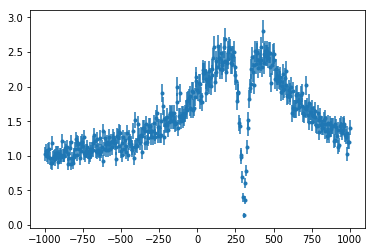

In [8]:
# generate monte carlo data for a simple 3 level system

N = 100000
t_excite = 50
t_radiative_decay = 200
t_shelving = 400
t_deshelving = 1000
dead_time = 0
offset = 300

excite_delays = np.random.exponential(t_excite, N)
radiative_delays = np.random.exponential(t_radiative_decay, N)
shelving_delays = np.random.exponential(t_shelving, N)
deshelving_delays = np.random.exponential(t_deshelving, N)

photon_emitted = radiative_delays < shelving_delays

delays = excite_delays + np.choose(
    photon_emitted,
    [shelving_delays + deshelving_delays, radiative_delays]
)
        
detection_times = np.cumsum(delays)[photon_emitted]
channel = np.random.randint(2, size=len(detection_times))

last_t2_index = len(detection_times)
mask = np.ones(last_t2_index, dtype=np.bool)

for i in range(last_t2_index):
        if mask[i]:
            if channel[i] == 0:
                for j in range(i+1, last_t2_index):
                    tau = (detection_times[j] - detection_times[i])
                    if tau > dead_time:
                        break
                    if channel[j] == 0:
                        mask[j] = False
            elif channel[i] == 1:
                for j in range(i+1, last_t2_index):
                    tau = (detection_times[j] - detection_times[i])
                    if tau > dead_time:
                        break
                    if channel[j] == 1:
                        mask[j] = False

channel = channel[mask]
detection_times = detection_times[mask]
detection_times[channel == 1] = detection_times[channel == 1] + offset
idx_array = np.argsort(detection_times)
detection_times = detection_times[idx_array]
channel = channel[idx_array]

t, g2, g2_error = pp.cycorr.corr(channel,
                                 detection_times, 
                                 cutofftime=1000,
                                 resolution=5, chan0=0, chan1=1)
plt.errorbar(t, g2, yerr=g2_error, fmt='.')


[[Model]]
    Model(g2_wrapped)
[[Fit Statistics]]
    # function evals   = 66
    # data points      = 400
    # variables        = 5
    chi-square         = 390.553
    reduced chi-square = 0.989
    Akaike info crit   = 0.439
    Bayesian info crit = 20.397
[[Variables]]
    tau0:          305.798857 +/- 0.368627 (0.12%) (init= 300)
    bgfactor:      0.02371194 +/- 0.017565 (74.08%) (init= 0.1)
    t_antibunch:   41.8658167 +/- 1.655139 (3.95%) (init= 200)
    A_0:           2.58328913 +/- 0.128684 (4.98%) (init= 2)
    t_0:           305.223757 +/- 7.181258 (2.35%) (init= 1000)
    g2_0:          0.04578890 +/- 0.032745 (71.51%)  == '( bgfactor**2 + 2*bgfactor ) / ( 1 + bgfactor )**2'
[[Correlations]] (unreported correlations are <  0.100)
    C(bgfactor, A_0)             =  0.839 
    C(t_antibunch, A_0)          =  0.832 
    C(t_antibunch, t_0)          = -0.673 
    C(A_0, t_0)                  = -0.657 
    C(bgfactor, t_antibunch)     =  0.548 
    C(tau0, bgfactor)        

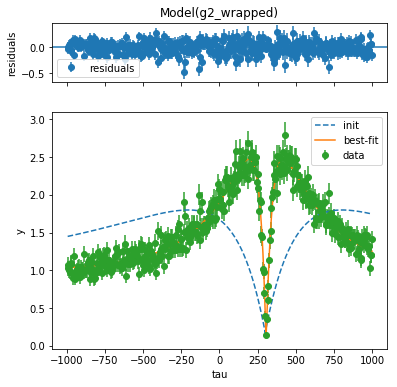

In [18]:
res = pp.fit_g2(t, g2,  g2_error,
                tau0=offset, t_antibunch=t_radiative_decay,
                t_bunch=[t_deshelving],
                a_bunch=[2])
res.plot()
print(res.fit_report())